In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Prepare some data
def foo(x):
    return x * np.sin(x) + 0.2 * x
#     return x ** 2

N = 32
X = np.concatenate(
    [
        np.random.uniform(low = -1.5, high = -0.5, size = (N // 8 * 4,)),
        np.random.uniform(low = 1, high = 1.5, size = (N // 8 * 2,)),
        np.random.uniform(low = -2.6, high = -2.3, size = (N // 8 * 2,))
    ])
# X = np.random.uniform(low = -2.6, high = 2.6, size = (N,))
Y = foo(X)

X_GT = np.linspace(-3, 3, num = 256)
Y_GT = foo(X_GT)

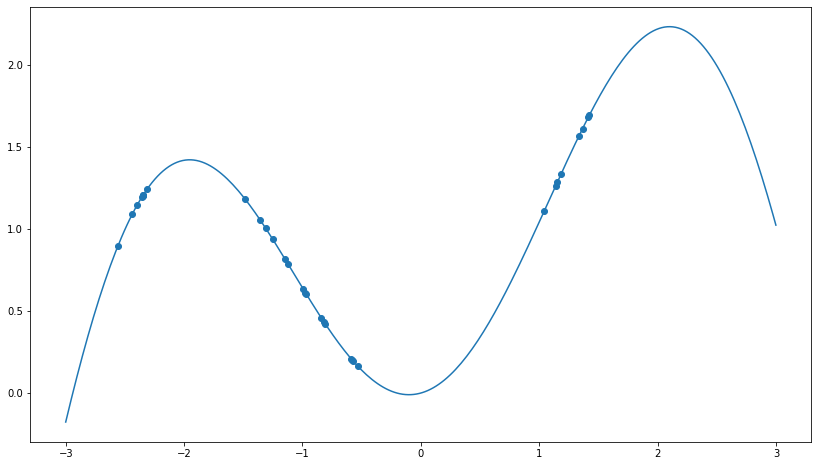

In [2]:
fig = plt.figure(figsize = (14, 8))
plt.scatter(X, Y)
plt.plot(X_GT, Y_GT)
plt.show()

In [3]:
import torch
from torch import nn

input_dim = 1
hidden_dim = 4096
output_dim = 1

# net_scale = 1 # large = NTK; small = MF

nonlin = nn.ReLU()

Y_mean_all = []
N_trials = 8

for trials in range(N_trials):
    
    print("Trial %d" % trials)
    
    net = nn.Sequential(
#         nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nonlin,
#             nn.Linear(hidden_dim, hidden_dim),
#             nonlin,
#             nn.Linear(hidden_dim, hidden_dim),
#         ),
        nn.Linear(input_dim, hidden_dim),
        nonlin,
    #     nn.Dropout(0.5),
        nn.Linear(hidden_dim, output_dim)
    )

    # optim = torch.optim.SGD(net.parameters(), lr=1e-4, weight_decay = 1e-3)
    optim = torch.optim.Adam(net.parameters(), lr=1e-3)
    # print(list(net.parameters()))

    net = net.cuda()
    Xs = torch.FloatTensor(X).cuda().view(-1, 1)
    Ys = torch.FloatTensor(Y).cuda().view(-1, 1)

    # lossFn = nn.MSELoss()
    lossFn = nn.L1Loss()
    
    # Record initialization
    if trials == N_trials - 1:
        net.eval()
        y_init = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
        y_init = net[1](ygp)
        Y_act_init_all = (ygp.unsqueeze(1) * net[-1].weight.unsqueeze(0)).squeeze().detach().cpu()

    net.train()

    steps = 20000
    for i in range(steps):
        pred = net(Xs)
        loss = lossFn(pred, Ys)
        optim.zero_grad()
        loss.backward()
        optim.step()

#         if i % (steps//10) == (steps // 10) - 1:
#             print("%d: %f" % (i + 1, loss))

    net.eval()

    # Random dropout samplings
    Y_pred = net(Xs).detach().cpu().squeeze()

    Y_GT_pred = []
    N_samples = 20
    for i in range(N_samples):
        ygp = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
        ygp = net[1](ygp)
        ygp = ygp * torch.randint(2, size = (ygp.shape[-1],), device = ygp.device).unsqueeze(0) * 2
        ygp = net[-1](ygp)
        Y_GT_pred.append(ygp.detach().cpu().squeeze())

    # Std
    ygp = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
    ygp = net[1](ygp)
    Y_act_all = (ygp.unsqueeze(1) * net[-1].weight.unsqueeze(0)).squeeze()
    Y_std = Y_act_all.std(dim = -1).detach().cpu()
    Y_mean = net(torch.FloatTensor(X_GT).cuda().view(-1, 1)).detach().cpu()
    
    Y_mean_all.append(Y_mean)

print(Y_act_all.shape)
print(Y_pred)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
torch.Size([256, 4096])
tensor([0.1555, 0.3990, 0.9753, 0.9279, 1.0993, 0.5685, 0.1160, 0.3655, 0.3739,
        0.7234, 0.8647, 0.1441, 0.7509, 0.1498, 0.5430, 0.5498, 1.6337, 1.5611,
        1.2374, 1.5132, 1.2835, 1.0620, 1.6446, 1.2128, 0.9652, 1.0233, 1.0770,
        1.1126, 1.0715, 0.7731, 1.0789, 1.0823])


In [4]:
# # Dropout-based subnet uncertainty
# net.eval()
# is_uncertain = True

# N_dropout_trials = 512
# all_logits = []
# recorder_identity(net)

# for batch in tqdm(test_dl, total = len(test_dl)):
    
#     x, y = batch
#     x = x.to(device)

#     disable_dropout(net)
#     record(net)

#     # For recording
#     logit = net(x)

#     enable_dropout(net)
#     replay(net)

#     logits = []
#     for i in range(N_dropout_trials):
    
#         logit = net(x)
#         logits.append(logit.detach().cpu())

#     all_logits.append(torch.stack(logits, dim = 0))
    
# all_logits = torch.cat(all_logits, dim = 1)
# recorder_identity(net)

# is_uncertain = False

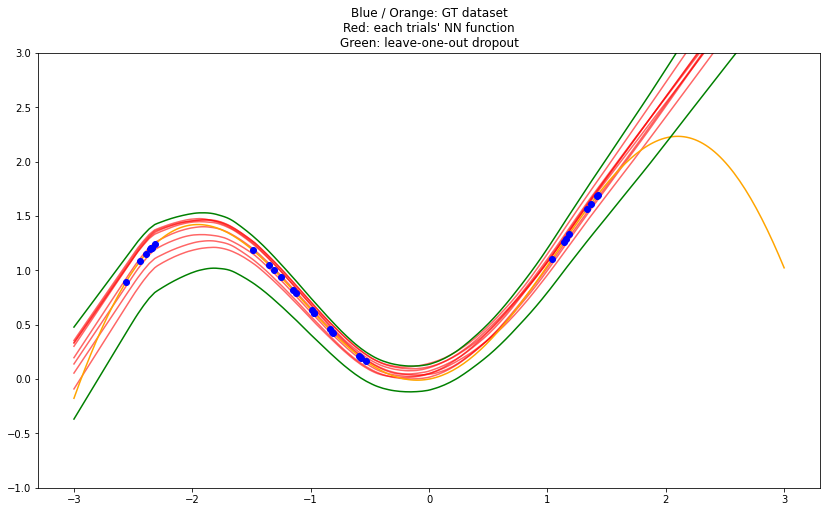

In [7]:
import math

Y_act_all = Y_act_all.detach().cpu()
fig = plt.figure(figsize = (14, 8))

# plt.scatter(X, Y_pred, c = 'blue')

for i in range(N_samples):
#     plt.plot(X_GT, Y_GT_pred[i], c = 'blue', alpha = 0.15)
    pass

Y_mean_mean = torch.stack(Y_mean_all).mean(dim = 0).squeeze()
for i in range(hidden_dim // 4):
#     plt.plot(X_GT, Y_mean_mean - (Y_act_all[:, i] * 20), c = 'green', alpha = 0.05)
#     plt.plot(X_GT, Y_mean_mean - ((Y_act_all[:, i] - Y_act_init_all[:, i]) * 20), c = 'green', alpha = 0.05)
#     plt.plot(X_GT, ((Y_act_all[:, i] - Y_act_init_all[:, i]) * 20), c = 'green', alpha = 0.02)
#     plt.plot(X_GT, (() * 20), c = 'blue', alpha = 0.02)
    pass

# Subnets
# divides = hidden_dim // 4
# for i in range(hidden_dim // divides):
#     Y_act_subnet = Y_act_all[:, (i*divides):((i+1)*divides)].sum(1) * (hidden_dim / divides / 2)
#     Y_act_init_subnet = Y_act_init_all[:, (i*divides):((i+1)*divides)].sum(1) * (hidden_dim / divides / 2)
#     plt.plot(X_GT, ((Y_act_subnet - Y_act_init_subnet)), c = 'green', alpha = 0.5)
#     plt.plot(X_GT, ((Y_act_subnet)), c = 'red', alpha = 0.3)
#     plt.plot(X_GT, ((Y_act_init_subnet)), c = 'blue', alpha = 0.3)
    
for i in range(N_trials):
    plt.plot(X_GT, 1 * (Y_mean_all[i].squeeze() - Y_mean_mean) + Y_mean_mean, c = 'red', alpha = 0.6)
    pass

plt.plot(X_GT, Y_GT, c = 'orange')
plt.scatter(X, Y, c = 'blue', alpha = 1, zorder = 100)

# plt.plot(X_GT, Y_mean[:, 0], c = 'blue')
plt.plot(X_GT, Y_mean[:, 0] + math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')
plt.plot(X_GT, Y_mean[:, 0] - math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')

plt.ylim(-1, 3.0)

# plt.title("Blue: NN (last trial)\nOrange: GT\nRed: each trials\nGreen: MC-stddev (last trial)")
# plt.title("Blue: Dataset\nRed: each trials' NN function\nGreen: MC-bound (stddev, last trial)")
plt.title("Blue / Orange: GT dataset\nRed: each trials' NN function\nGreen: leave-one-out dropout")

plt.show()